In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Manhattan

In [2]:
df_man = pd.read_parquet(r"..\data\final_processed\Manhattan - all.parquet.gz")
df_man = df_man.set_index("timestamp_hour")
df_man['txn_date'] = pd.to_datetime(df_man['txn_date'])
df_man = df_man[
    (df_man['txn_date'] >= '2019-02-01') & (df_man['txn_date'] <= '2024-12-31')
]
df_man['txn_month'] = df_man['txn_date'].apply(lambda x: pd.Timestamp(year=x.year, month=x.month, day=1))
print(df_man.shape)
df_man.head()

(48936, 17)


,txn_date,txn_hour,num_txns_Yellow Taxi Trip Records,num_txns_For-Hire Vehicle Trip Records,num_txns_Green Taxi Trip Records,num_txns_Uber,num_txns_Lyft,num_txns_Juno,num_txns_Via,total_amount_Yellow Taxi Trip Records,total_amount_For-Hire Vehicle Trip Records,total_amount_Green Taxi Trip Records,total_amount_Uber,total_amount_Lyft,total_amount_Juno,total_amount_Via,txn_month
timestamp_hour,,,,,,,,,,,,,,,,,
2019-02-01 00:00:00,2019-02-01,0,6347,109,212,12210,5261,1056,0,48891.282940,0.0,2738.758667,0.0,0.0,0.0,0.0,2019-02-01
2019-02-01 01:00:00,2019-02-01,1,3694,44,128,7286,3090,646,0,31448.238410,0.0,1749.783333,0.0,0.0,0.0,0.0,2019-02-01
2019-02-01 02:00:00,2019-02-01,2,2255,42,76,4610,1988,446,0,22070.332000,0.0,1022.620000,0.0,0.0,0.0,0.0,2019-02-01
2019-02-01 03:00:00,2019-02-01,3,1591,28,55,3504,1467,335,0,18566.660682,0.0,934.490000,0.0,0.0,0.0,0.0,2019-02-01
2019-02-01 04:00:00,2019-02-01,4,1515,67,64,3666,1638,331,0,19226.280129,0.0,1084.690000,0.0,0.0,0.0,0.0,2019-02-01


### Check if all dates and hours are available

In [3]:
grouped = df_man.groupby('txn_date')['txn_hour'].nunique()
grouped[grouped < 24]

Series([], Name: txn_hour, dtype: int64)

# Naive Model

### Evaluation helper function

In [10]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# We use this helper function to evaluate model performance
def evaluate(y_true, y_pred):
    # Evaluate the model using RMSE and MAE
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R2: {r2}')
    print(f'MAPE: {mape}')

    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

### Forecasting with Day - 1 and Week - 1 values

In [31]:
df_naive = pd.DataFrame(df_man[(df_man['txn_date'] >= '2024-07-25') & (df_man['txn_date'] <= '2024-08-31')]["num_txns_Uber"])
df_naive['forecast_d-1'] = df_naive['num_txns_Uber'].shift(24)
df_naive['forecast_w-1'] = df_naive['num_txns_Uber'].shift(7 * 24)
df_naive = df_naive[df_man['txn_date'] >= '2024-08-01'] # Filter Aug 2024 data
df_naive.head()

print("d-1")
_ = evaluate(df_naive["num_txns_Uber"], df_naive["forecast_d-1"])
print("\n")

print("W-1")
_ = evaluate(df_naive["num_txns_Uber"], df_naive["forecast_w-1"])

d-1
MAE: 2234.6155913978496
MSE: 12097025.416666666
RMSE: 3478.0778336125063
R2: 0.6824650328567381
MAPE: 19.862698470711617


W-1
MAE: 1118.1155913978494
MSE: 3695243.9166666665
RMSE: 1922.301723628907
R2: 0.9030034975334944
MAPE: 7.221028038486764


Boolean Series key will be reindexed to match DataFrame index.


Previous week's data is a good predictor.

# Feature engineering

* Day of week
* Month
* Day of month
* Quarter of year
* Holidays (extracted from the ``holidays`` package)
* Identification of peak hours (6:00-9:00, 17:00-21:00)
* Time-lagged features
* Rolling average
* Cyclical Features (cosine and sine of day of month)

### Get month, day, and day of week from the txn_date column 

In [12]:
# Map the weekday names to numbers
day_mapping = {'Sunday': 0, 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 
               'Thursday': 4, 'Friday': 5, 'Saturday': 6}
df_man['week_day'] = df_man['txn_date'].dt.day_name().map(day_mapping)

# Day
df_man['day_of_month'] = df_man['txn_date'].dt.day
df_man['is_weekend'] = df_man['week_day'].isin([5, 6]).astype(int)
df_man['is_monday'] = (df_man['week_day'] == 0).astype(int)
df_man['is_friday'] = (df_man['week_day'] == 4).astype(int)

# Month
df_man['month'] = df_man['txn_date'].dt.month

# Quarter
df_man['quarter'] = df_man['txn_date'].dt.quarter

### Holidays

In [13]:
import holidays

ny_holidays = holidays.US(years=[2019, 2020, 2021, 2022, 2023, 2024], state='NY')
df_man['is_holiday'] = df_man['txn_date'].dt.date.isin(ny_holidays).astype(int)
df_man['is_holiday_next_day'] = df_man['is_holiday'].shift(-24)
df_man['is_holiday_previous_day'] = df_man['is_holiday'].shift(24)
df_man['is_long_weekend'] = (
    (df_man['is_holiday'] == 1) & 
    ((df_man['week_day'].isin([0, 4, 5, 6])) | 
     (df_man['is_holiday_next_day'] == 1) | 
     (df_man['is_holiday_previous_day'] == 1))
).astype(int)

# Fill next and previous day is holiday (edges of the dataframe)
df_man[['is_holiday_next_day', 'is_holiday_previous_day']] = df_man[['is_holiday_next_day', 'is_holiday_previous_day']].fillna(0)

### Peak hours

In [14]:
df_man['is_rush_hour'] = df_man['txn_hour'].isin([6, 7, 8, 9, 16, 17, 18, 19, 20]).astype(int)
df_man['is_business_hour'] = df_man['txn_hour'].isin(range(9, 18)).astype(int)
df_man['is_night_hour'] = df_man['txn_hour'].isin(list(range(22, 24)) + list(range(0, 5))).astype(int)

### Cyclical features

In [15]:
# Apply the sine and cosine transformations
df_man['sin_hour'] = np.sin(2 * np.pi * df_man['txn_hour'] / 24)
df_man['cos_hour'] = np.cos(2 * np.pi * df_man['txn_hour'] / 24)

### Time-Lagged features

In [16]:
# Select only the features and use 2021 data
df = (
    df_man
   # [(df_man['txn_date'] >= '2020-11-01')]
    [["txn_date", "quarter", "month", "day_of_month", "txn_hour", 
      "week_day", 'is_weekend', 'is_monday', 'is_friday', 
      'is_holiday', 'is_holiday_next_day','is_holiday_previous_day', 'is_long_weekend', 
      'is_rush_hour', 'is_business_hour', 'is_night_hour',
      'sin_hour', 'cos_hour',
      "num_txns_Uber"]]
)

# Create lagged features for the last 23 hours
for i in range(1, 24):
    df.loc[:, f'lag_{i}'] = df['num_txns_Uber'].shift(i)

# Daily lags
lagged_hrs = [24, 48, 72, 96, 120, 144]
for i in lagged_hrs:
    df.loc[:, f'lag_{i}'] = df['num_txns_Uber'].shift(i)

# Weekly lags
lagged_hrs = [168, 336, 504, 672]
for i in lagged_hrs:
    df.loc[:, f'lag_{i}'] = df['num_txns_Uber'].shift(i)

# Monthly lags
lagged_hrs = [720, 1440, 2160, 2880]
for i in lagged_hrs:
    df.loc[:, f'lag_{i}'] = df['num_txns_Uber'].shift(i)

C:\Users\tonba\AppData\Local\Temp\ipykernel_29472\1274279997.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, f'lag_{i}'] = df['num_txns_Uber'].shift(i)
C:\Users\tonba\AppData\Local\Temp\ipykernel_29472\1274279997.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, f'lag_{i}'] = df['num_txns_Uber'].shift(i)
C:\Users\tonba\AppData\Local\Temp\ipykernel_29472\1274279997.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

### Rolling averages

In [17]:
def daily_lags_rolling_avg(df, target_col):
    # Create individual lag features
    lag_24 = df[target_col].shift(24)
    lag_48 = df[target_col].shift(48)
    lag_72 = df[target_col].shift(72)
    
    # Calculate the average of exactly these three points
    rolling_avg = pd.concat([lag_24, lag_48, lag_72], axis=1).mean(axis=1)
    std = pd.concat([lag_24, lag_48, lag_72], axis=1).std(axis=1)
    return rolling_avg, std


def weekly_lags_rolling_avg(df, target_col):
    # Create individual lag features
    lag_w1 = df[target_col].shift(168)
    lag_w2 = df[target_col].shift(336)
    lag_w3 = df[target_col].shift(504)
    lag_w4 = df[target_col].shift(672)
    
    # Calculate the average of exactly these three points
    rolling_avg = pd.concat([lag_w1, lag_w2, lag_w3, lag_w4], axis=1).mean(axis=1)
    std = pd.concat([lag_w1, lag_w2, lag_w3, lag_w4], axis=1).std(axis=1)
    
    return rolling_avg, std

# Daily lags
df['rolling_avg_24_48_72_lags'], df["std_24_48_72_lags"] = daily_lags_rolling_avg(df, 'num_txns_Uber')

# Weekly lags
df['rolling_avg_w1-w4_lags'], df["std_w1-w4_lags"] = weekly_lags_rolling_avg(df, 'num_txns_Uber')

# Time Series modeling

### Train-Test split

We use January 2021 to July 2024 data as the training set and August 2024 as the test/holdout set.

In [18]:
# Training data
df_train = (
    df
    [(df_man['txn_date'] >= '2021-01-01') & (df['txn_date'] < "2024-08-01")]
    .drop("txn_date", axis=1)
    #.dropna()
)
X_train = df_train.drop("num_txns_Uber", axis=1).to_numpy()
y_train = df_train["num_txns_Uber"].to_numpy()

# Holdout data
df_test = (
    df
    [df['txn_date'] >= "2024-08-01"]
    .drop("txn_date", axis=1)
    .fillna(0) # is_holiday_next_day is causing NULLs since the information of the next days are unavailable
)
X_test = df_test.drop("num_txns_Uber", axis=1).to_numpy()
y_test = df_test["num_txns_Uber"].to_numpy()

# Feature names
feature_names = df_train.drop("num_txns_Uber", axis=1).columns.to_list()

### XGBoost Regression Model

We use Optuna for Bayesian hyperparameter tuning.

In [19]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters for tuning
    param = {
        'objective': 'reg:squarederror',
        'n_estimators': 300, # Keep fixed
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 0.3, log=True),  # Replaced suggest_loguniform
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Replaced suggest_uniform
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Replaced suggest_uniform
        'gamma': trial.suggest_float('gamma', 0, 1),  # Replaced suggest_uniform
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e2, log=True),  # Replaced suggest_loguniform
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1e2, log=True),  # Replaced suggest_loguniform
        'n_jobs': -1,
        'random_state': 42,
        'verbosity': 0
    }
    
    # Initialize the XGBoost regressor with the suggested hyperparameters
    model = xgb.XGBRegressor(**param)
    
    # Fit the model
    model.fit(X_train, y_train, verbose=False)
    
    # Predict on the validation set
    y_pred = model.predict(X_test)
    
    # Calculate root mean squared error as the objective to minimize
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse
    
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

# Get the best hyperparameters found by Optuna
best_params = study.best_params
print("Best hyperparameters found: ", best_params)

[I 2024-11-17 21:19:01,786] A new study created in memory with name: no-name-22afbfbb-133f-43c4-a020-06b0b7870fbf


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-11-17 21:19:06,256] Trial 0 finished with value: 5715.128911395178 and parameters: {'learning_rate': 0.0002869866624991608, 'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.8324568145400808, 'colsample_bytree': 0.7619911164871382, 'gamma': 0.5147732489013277, 'reg_alpha': 0.30813332079801314, 'reg_lambda': 2.2641486938879796}. Best is trial 0 with value: 5715.128911395178.
[I 2024-11-17 21:19:37,831] Trial 1 finished with value: 5434.174339106664 and parameters: {'learning_rate': 0.00045562753723699486, 'max_depth': 14, 'min_child_weight': 2, 'subsample': 0.9878818160109522, 'colsample_bytree': 0.7824910106514655, 'gamma': 0.9877965565797576, 'reg_alpha': 50.17499550176644, 'reg_lambda': 0.17956332923800933}. Best is trial 1 with value: 5434.174339106664.
[I 2024-11-17 21:19:43,850] Trial 2 finished with value: 893.6494100877527 and parameters: {'learning_rate': 0.024606779814301448, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.5959536740885656, 'colsample_bytree

### Train the best model

In [21]:
import joblib

# Train the best model
best_model = xgb.XGBRegressor(**best_params, n_estimators=300, n_jobs = -1, random_state=42)
best_model.fit(X_train, y_train)

# Log the model
model_filename = "../models/manhattan_xgboost.joblib"
joblib.dump(best_model, model_filename)

# Make predictions
y_pred = best_model.predict(X_test)

# Model evaluation
results = evaluate(y_test, y_pred)

MAE: 498.66382951633904
MSE: 747543.0851137784
RMSE: 864.6057396951389
R2: 0.9803777324760566
MAPE: 3.539360737096961


### Model results

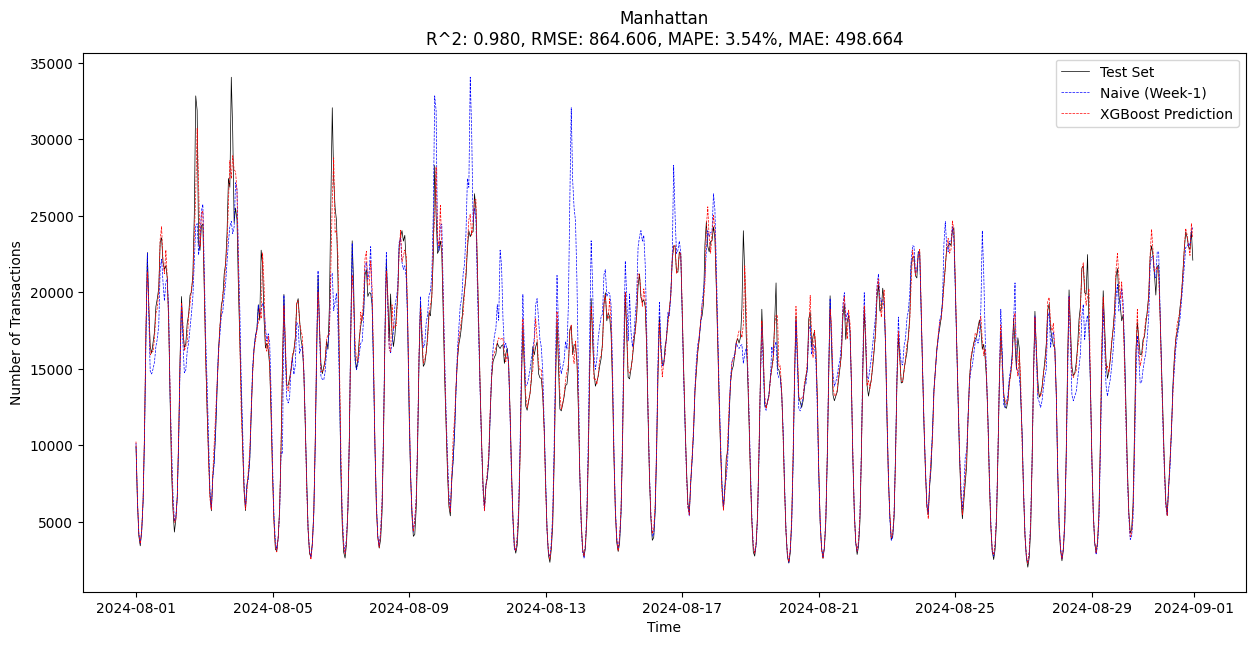

In [25]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 7))

# Plotting the predictions
ax.plot(df_test.index, df_test["num_txns_Uber"], label="Test Set", color='black', lw=.5)
ax.plot(df_test.index, df_naive["forecast_w-1"], label="Naive (Week-1)", ls='--', color='blue', lw=.5)
ax.plot(df_test.index, y_pred, label="XGBoost Prediction", ls='--', color='red', lw=.5)

# Adding labels, title, and legend for better clarity
ax.set_xlabel('Time')
ax.set_ylabel('Number of Transactions')
ax.set_title(f'Manhattan\nR^2: {results["R2"]:.3f}, RMSE: {results["RMSE"]:.3f}, MAPE: {results["MAPE"]:.2f}%, MAE: {results["MAE"]:.3f}')
ax.legend()

img_filename = r"../data/images/Manhattan - model comparison.jpeg"
plt.savefig(img_filename, dpi=300, bbox_inches='tight')
plt.show()

# Feature importance analysis

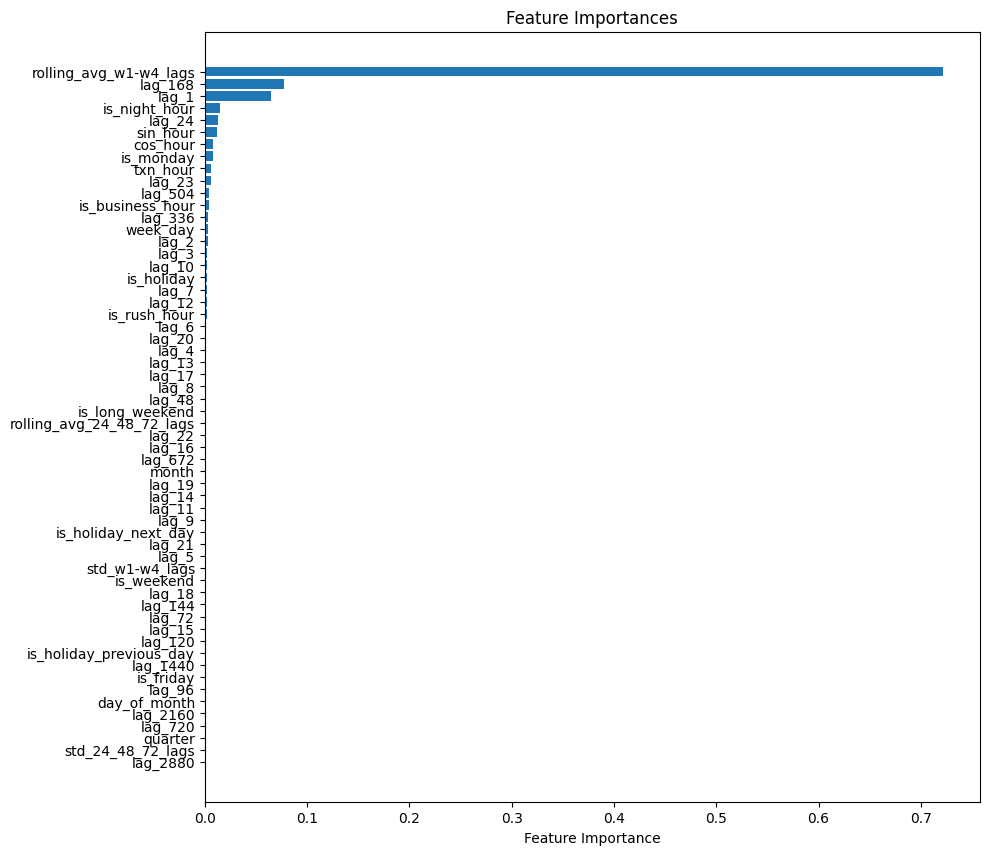

In [26]:
feature_impt = dict(zip(feature_names, best_model.feature_importances_))

# Sort the dictionary by feature importance in descending order
sorted_importance = dict(sorted(feature_impt.items(), 
                                key=lambda item: item[1], reverse=False))

# Extract the feature names and importances for plotting
features = list(sorted_importance.keys())
importances = list(sorted_importance.values())

# Plot the feature importances
plt.figure(figsize=(10, 10))
plt.barh(features, importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.savefig("../data/images/Manhattan - XGBoost model feature importances.jpeg", dpi=300, bbox_inches='tight')
plt.show()

### SHAP

[21:45:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


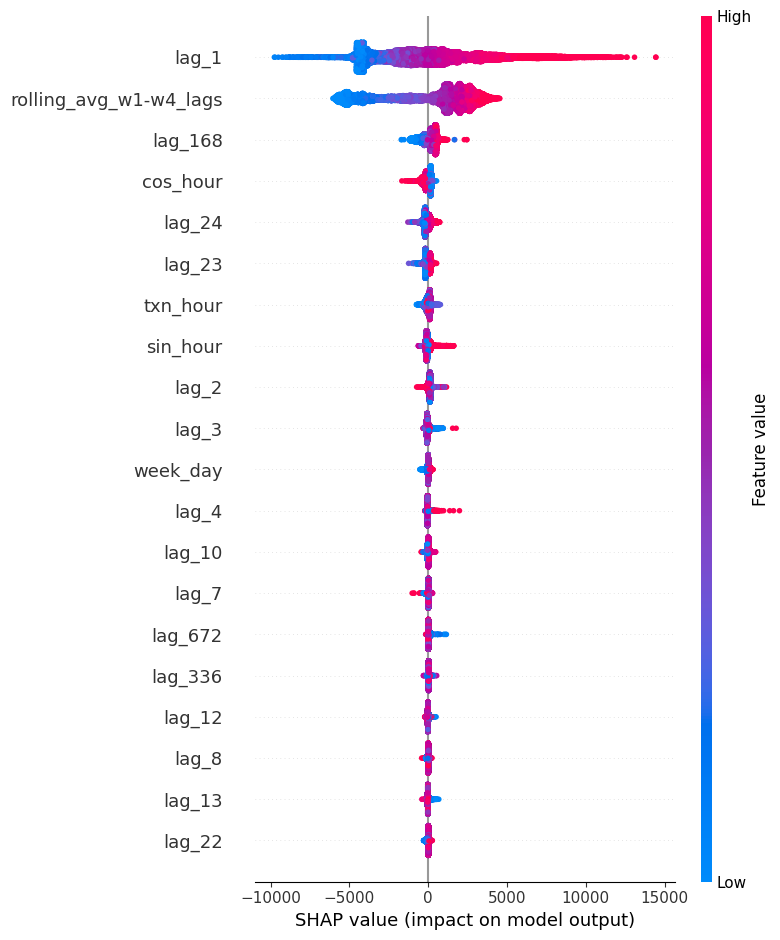

In [38]:
import shap

# Initialize SHAP explainer for the XGBoost model
explainer = shap.TreeExplainer(best_model, n_jobs=-1)

# Compute SHAP values for the dataset (assuming X_train is your input data)
shap_values = explainer.shap_values(X_train)

# Plot summary of SHAP values (feature importances)
#fig, ax = plt.subplots(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, feature_names=feature_names, show=False, max_display=20)

# Save the plot as a JPEG file
plt.savefig(r"../data/images/Manhattan - XGBoost model SHAP beeswarm plot.jpeg", dpi=300, bbox_inches='tight')
plt.show()

### MLFlow logging

In [45]:
import mlflow
from mlflow.models.signature import infer_signature

# Create a new experiment
mlflow.set_tracking_uri("../../../../MLFlow Experiments/mlruns")
experiment_name = "NYC TLC Time Series Forecasting - Manhattan"
experiment_id = mlflow.set_experiment(experiment_name) # create_experiment if exp doesnt exist
print(f"Experiment created with ID: {experiment_id}")

with mlflow.start_run():
    # Log model parameters
    for param_name, param_value in best_params.items():
        mlflow.log_param(param_name, param_value)
    
    # Log the model
    signature = infer_signature(X_train, best_model.predict(X_train))
    mlflow.xgboost.log_model(best_model, "xgboost_model", signature=signature)

    # Log the model artifact
    mlflow.log_artifact(model_filename)

    # Logging the evaluation
    for metric_name, metric_value in results.items():
        mlflow.log_metric(metric_name, metric_value)

    # Saving the images
    mlflow.log_artifact("../data/images/Manhattan - model comparison.jpeg")
    mlflow.log_artifact("../data/images/Manhattan - XGBoost model feature importances.jpeg")
    mlflow.log_artifact("../data/images/Manhattan - XGBoost model SHAP beeswarm plot.jpeg")

Experiment created with ID: <Experiment: artifact_location=('file:///C:/Users/tonba/OneDrive/Desktop/AIM MSDS/4 '
 'ML2/nyc_tlc_taxi_ride_hailing_project/notebooks/../../../../MLFlow '
 'Experiments/mlruns/128452972647761925'), creation_time=1731849415810, experiment_id='128452972647761925', last_update_time=1731849415810, lifecycle_stage='active', name='NYC TLC Time Series Forecasting - Manhattan', tags={}>


[21:52:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
